In [1]:
from mangaki.algo.svd import MangakiSVD
from mangaki.algo.als import MangakiALS
from mangaki.algo.pca import MangakiPCA
from mangaki.algo.knn import MangakiKNN
import numpy as np
from mangaki.utils.values import rating_values
from mangaki.algo.dataset import Dataset
from mangaki.algo.fit_algo import fit_algo, get_algo_backup, get_dataset_backup

dataset = Dataset()
dataset.load_csv('ratings.csv', convert=lambda choice: rating_values[choice], title_filename='works.csv')
titles = dataset.titles

In [3]:
algo = MangakiALS(nb_iterations=10)
algo.set_parameters(dataset.anonymized.nb_users, dataset.anonymized.nb_works)
algo.fit(dataset.anonymized.X, dataset.anonymized.y)

print(algo.predict(dataset.anonymized.X)[:6])
print(dataset.anonymized.y[:6])

Computing M: (2112 × 10031)


Chrono: fill and center matrix [0q, 824ms]
Chrono: factor matrix [0q, 7107ms]


Shapes (2112, 20) (20, 10031)
[ 0.19785066  0.95783557  1.15636005  0.56728735  1.72150522 -0.18363108]
[-0.5 -0.5  2.   0.5  2.   0.5]


## Find popular works and users

In [4]:
from collections import Counter

NB = 50

popular_users = Counter([user_id for user_id, _ in dataset.anonymized.X])
popular_works = Counter([work_id for _, work_id in dataset.anonymized.X])

popular_user_ids = [user_id for user_id, _ in popular_users.most_common(NB)]
popular_work_ids = [work_id for work_id, _ in popular_works.most_common(NB)]

In [5]:
titles[:10]

array(['Death Note', "L'Attaque des Titans",
       'Fullmetal Alchemist: Brotherhood', 'Princesse Mononoké',
       'Le Voyage de Chihiro', 'Naruto', 'Sword Art Online',
       'Fullmetal Alchemist', 'Naruto: Shippuuden', 'Bleach'],
      dtype=object)

## Visualize anime embeddings using matplotlib

<IPython.core.display.Javascript object>


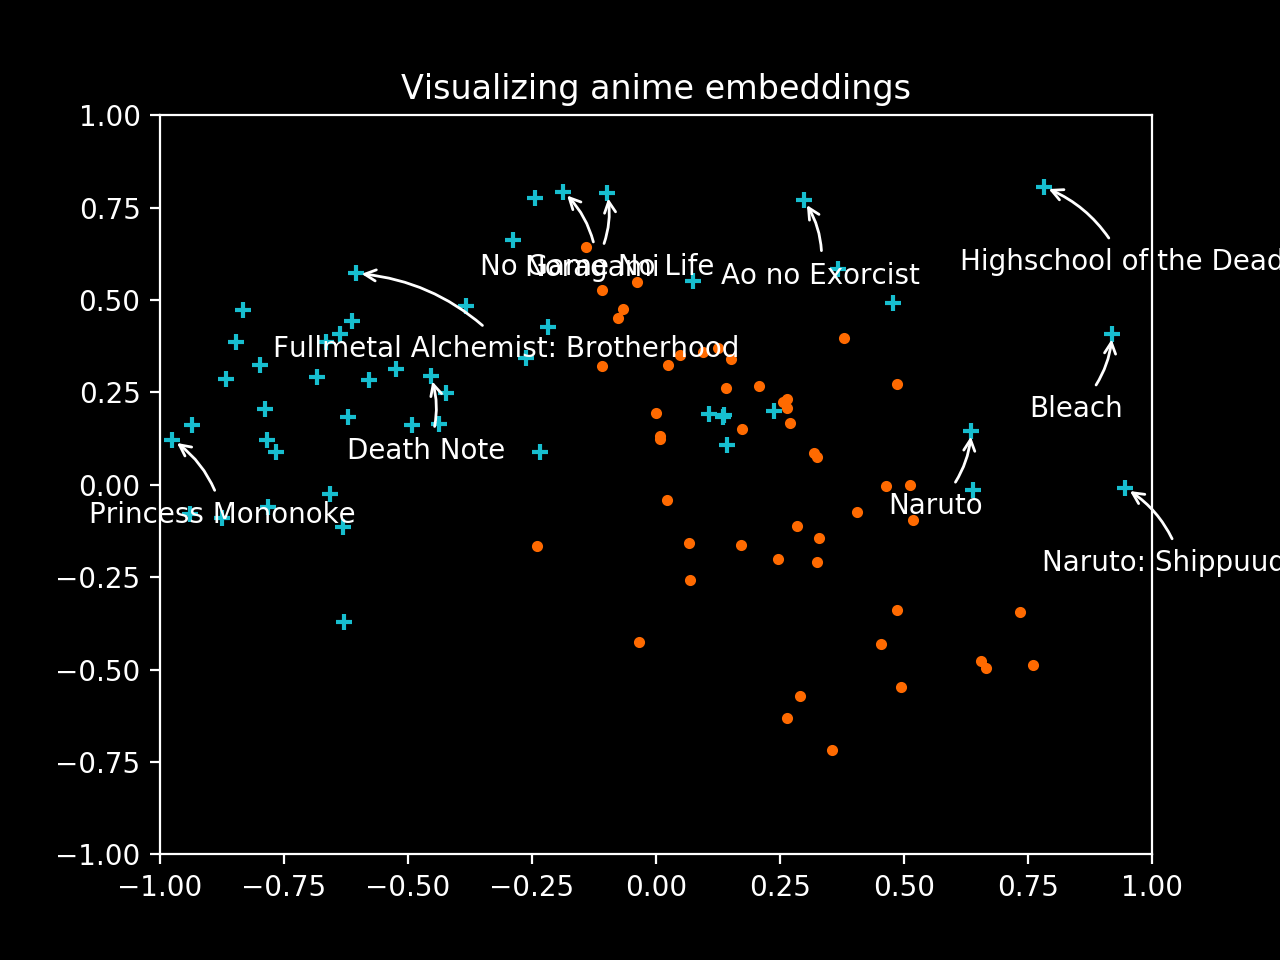

In [6]:
%matplotlib notebook
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
plt.style.use('dark_background')

svd = TruncatedSVD()

class MangakiViz:
    def __init__(self, title):
        self.fig, self.ax = plt.subplots()
        plt.xlim((-1, 1))
        plt.ylim((-1, 1))
        plt.title(title)
        
    def load_points(self, V, displayed_ids, marker='.', color='#FF6A00', titles=None):
        V2 = svd.fit_transform(V)
        self.ax.scatter(V2[displayed_ids, 0], V2[displayed_ids, 1], marker=marker, c=color, picker=True)
        if titles is not None:
            self.V2 = V2
            self.displayed_ids = displayed_ids
            self.title_of_point = dict([(tuple(self.V2[entity_id].tolist()), titles[entity_id] if entity_id != 3 else 'Princess Mononoke') for entity_id in self.displayed_ids])
            self.fig.canvas.mpl_connect('pick_event', self.onpick)
    
    def display_title(self, x, y):
        plt.annotate(self.title_of_point[(x, y)], xy=(x, y), xycoords='data',
            xytext=(-30, -30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=.2")
            )
    
    def onpick(self, event):
        ind = self.displayed_ids[event.ind[0]]
        x, y = self.V2[ind]
        self.display_title(x, y)
    
    def show_popular(self):
        for famous_pos in [0, 3, 5]:
            x, y = self.V2[self.displayed_ids[famous_pos]]
            self.display_title(x, y)
    
    def save(self, filename):
        self.fig.savefig(filename, format='pdf')
        plt.close()

U = algo.U
V = algo.VT.T
titles = dataset.titles
viz = MangakiViz('Visualizing anime embeddings')
viz.load_points(U, popular_user_ids)
viz.load_points(V, popular_work_ids, '+', 'tab:cyan', titles)
viz.show_popular()

## This below was just to generate the slides for Hacker News Kansai

In [7]:
V_ids = np.arange(20).repeat(2)
U_ids = V_ids.copy()[1:]

In [13]:
with open('/tmp/log.txt') as f:
    plot_titles = ['Start with random points'] + f.read().splitlines()

for t, (uid_t, vid_t) in enumerate(zip(U_ids, V_ids)):
    print(t, uid_t, vid_t, plot_titles[t])
    viz = MangakiViz(plot_titles[t])
    U = np.load('U{:d}.npy'.format(uid_t))
    V = np.load('V{:d}.npy'.format(vid_t))
    viz.load_points(U, popular_user_ids)
    viz.load_points(V, popular_work_ids, '+', 'tab:cyan', titles)
    viz.show_popular()
    viz.save('/Users/jilljenn/Desktop/hnkansai/figures/embed{:d}.pdf'.format(t))

0 0 0 Start with random points
1 1 0 Iteration 1: learn users fix works (RMSE: 1.068)
2 1 1 Iteration 1: learn works fix users (RMSE: 1.020)
3 2 1 Iteration 2: learn users fix works (RMSE: 0.977)
4 2 2 Iteration 2: learn works fix users (RMSE: 0.963)
5 3 2 Iteration 3: learn users fix works (RMSE: 0.945)
6 3 3 Iteration 3: learn works fix users (RMSE: 0.940)
7 4 3 Iteration 4: learn users fix works (RMSE: 0.931)
8 4 4 Iteration 4: learn works fix users (RMSE: 0.928)
9 5 4 Iteration 5: learn users fix works (RMSE: 0.923)
10 5 5 Iteration 5: learn works fix users (RMSE: 0.922)
11 6 5 Iteration 6: learn users fix works (RMSE: 0.918)
12 6 6 Iteration 6: learn works fix users (RMSE: 0.917)
13 7 6 Iteration 7: learn users fix works (RMSE: 0.915)
14 7 7 Iteration 7: learn works fix users (RMSE: 0.914)
15 8 7 Iteration 8: learn users fix works (RMSE: 0.913)
16 8 8 Iteration 8: learn works fix users (RMSE: 0.912)
17 9 8 Iteration 9: learn users fix works (RMSE: 0.911)
18 9 9 Iteration 9: learn 